# Уравнение теплопроводности
## Дз №10

In [2]:
from abc import abstractmethod
from typing import Callable, Optional, List

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from tqdm import tqdm

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
OneArgFunc = Callable[[float], float]
CoordFunc = OneArgFunc
TimeFunc = OneArgFunc

TwoArgFunc = Callable[[float, float], float]
CoordAndTimeFunc = TwoArgFunc

In [5]:
class HeatEquation:
    def __init__(self, f: CoordAndTimeFunc = lambda x, t: 0,
                 left: TimeFunc = lambda t: 0,
                 right: TimeFunc = lambda t: 0,
                 initial: CoordFunc = lambda x: 0,
                 a: float=1,
                 x_precision: int=100,
                 time_precision: int=100,
                 end_time: float=10,
                 kappa: float=1):
        self.f = f
        self.left = left
        self.right = right
        self.a = a
        self.k = kappa
        self.n = x_precision
        self.time_precision = time_precision
        self.end_time = end_time

        self.x_net = np.linspace(0, a, x_precision)
        self.h = self.x_net[1] - self.x_net[0]
        self.time_net = np.linspace(0, end_time, time_precision)
        self.tau = self.time_net[1] - self.time_net[0]

        self.layers = [[initial(x) for x in self.x_net]]

        convergence_error = self.check_convergence()
        if convergence_error is not None:
            print(f'Метод может быть не стабильным с этими параметрами. {convergence_error}')

        self.solve()


    @abstractmethod
    def generate_next_layer(self, time):
        ...

    def check_convergence(self) -> Optional[str]:
        return None

    def solve(self):
        for time in tqdm(np.linspace(0, self.end_time, self.time_precision)[1:], leave=False):
            self.layers.append(self.generate_next_layer(time))

    def plot(self):
        fig, axis = plt.subplots(1, 2)
        fig.set_size_inches(24, 8)

        ax = sns.heatmap(np.array(self.layers).T, ax=axis[0])
        ax.set_yticks([])
        ax.set_xticks([])

        sns.lineplot(x=self.time_net, y=[left(t) for t in self.time_net], label='Левый конец', ax=axis[1])
        sns.lineplot(x=self.time_net, y=[right(t) for t in self.time_net], label='Правый конец', ax=axis[1])
        sns.lineplot(x=self.time_net, y=[layer[self.n // 2] for layer in self.layers], label='Середина', ax=axis[1])

        plt.show()

In [6]:
class HeatEquationWithExplicitSchema(HeatEquation):
    def check_convergence(self) -> Optional[str]:
        if 2 * self.k * self.tau > self.h ** 2:
            return 'Для устойчивости должно выполняться: 2kt <= h**2'
        return None

    def generate_next_layer(self, time) -> List[float]:
        u0 = self.left(time)
        new_layer = [u0]
        prev_layer = self.layers[-1]

        for i, x in list(enumerate(self.x_net))[1:-1]:
            u_c = prev_layer[i - 1] - 2 * prev_layer[i] + prev_layer[i + 1]
            u_n = self.tau * ((self.k / self.h ** 2) * u_c + self.f(x, time)) + prev_layer[i]
            new_layer.append(u_n)

        u_last = self.right(time)
        new_layer.append(u_last)
        return new_layer

In [7]:
class HeatEquationWithNonExplicitSchema(HeatEquation):
    def __init__(self, f: CoordAndTimeFunc = lambda x, t: 0,
                 left: TimeFunc = lambda t: 0,
                 right: TimeFunc = lambda t: 0,
                 initial: CoordFunc = lambda x: 0,
                 a: float = 1,
                 x_precision: int = 100,
                 time_precision: int = 100,
                 end_time: float = 10,
                 kappa: float = 1):
        self.S = None
        super().__init__(f, left, right, initial, a, x_precision, time_precision, end_time, kappa)

    def generate_S_matrix(self, n):
        a = - self.k / self.h ** 2
        b = 1 / self.tau + 2 * self.k / self.h ** 2

        first_row = np.zeros(n)
        first_row[0] = b
        first_row[1] = a
        S = [first_row]

        for i in range(n - 2):
            row = np.zeros(n)
            row[i] = row[i + 2] = a
            row[i + 1] = b
            S.append(row)

        last_row = np.zeros(n)
        last_row[n - 2] = a
        last_row[n - 1] = b
        S.append(last_row)

        return np.array(S)


    def generate_next_layer(self, time):
        if self.S is None:
            self.S = self.generate_S_matrix(self.n - 2)

        u0 = self.left(time)
        u_last = self.right(time)
        prev_layer = self.layers[-1]

        b = np.zeros(self.n - 2)

        koef = self.k / self.h ** 2

        b[0] = prev_layer[1] / self.tau + self.f(self.x_net[1], time + self.tau) + u0 * koef
        b[self.n - 3] = prev_layer[-2] / self.tau + self.f(self.x_net[-2], time + self.tau) + u_last * koef

        for i, x in list(enumerate(self.x_net))[2:-2]:
            b[i - 1] = prev_layer[i] / self.tau + self.f(x, time + self.tau)

        solution = np.linalg.solve(self.S, b)
        return [u0, *solution, u_last]

In [8]:
def get_equation_solver(schema: str):
    if schema == 'explicit':
        return HeatEquationWithExplicitSchema
    elif schema == 'non_explicit':
        return HeatEquationWithNonExplicitSchema
    else:
        raise ValueError('Unknown schema')

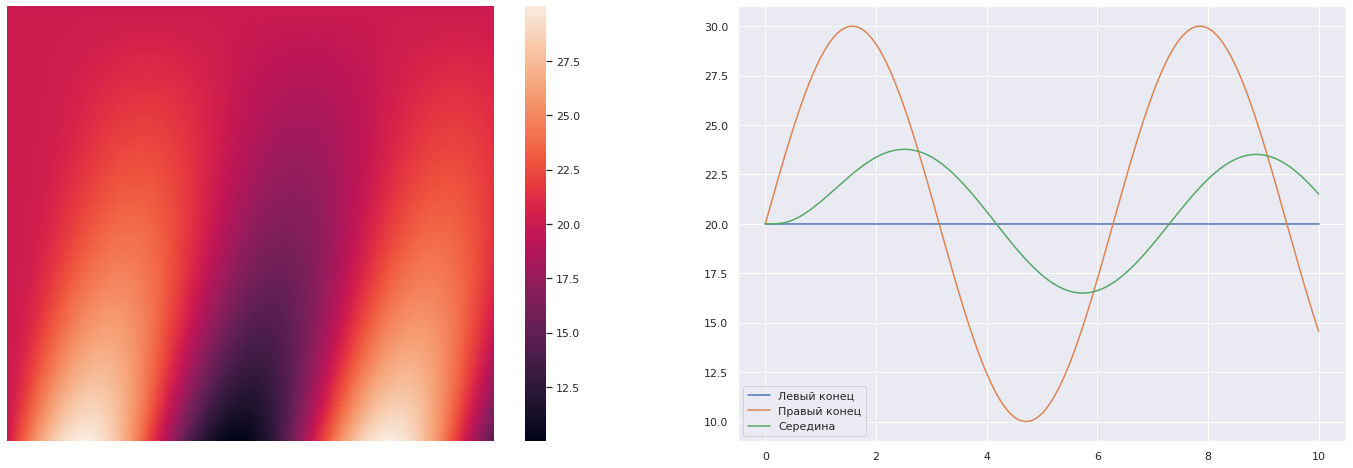

In [9]:
explicit_schema = get_equation_solver('non_explicit')
right = lambda t: 20 + np.sin(t) * 10
left = lambda t: 20
f = lambda x, t: 0
initial = lambda x: 20
explicit_schema(left=left, right=right, kappa=0.1, x_precision=100, time_precision=1000, f=f, initial=initial).plot()

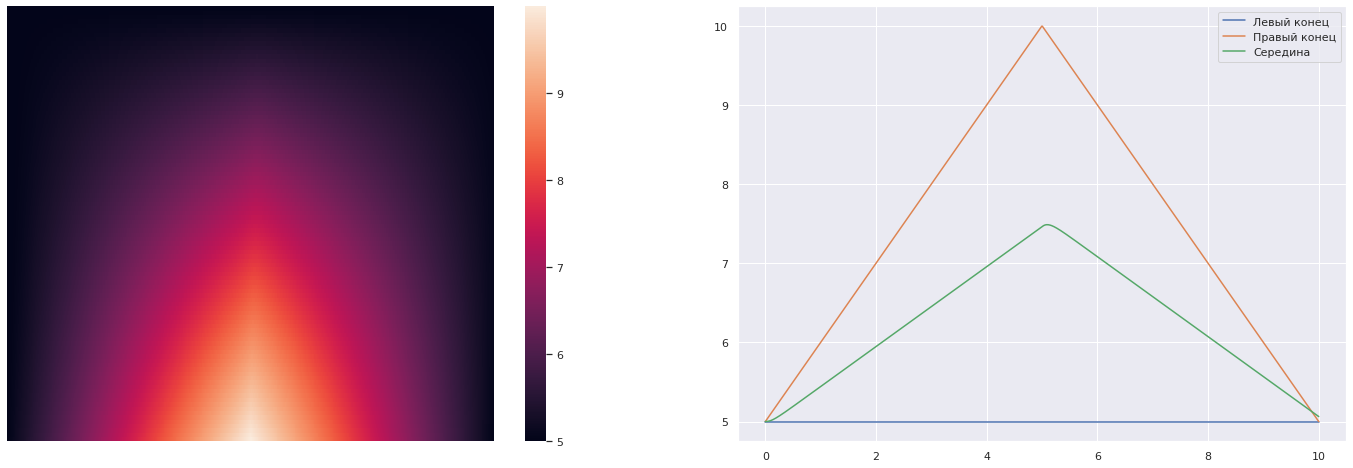

In [10]:
explicit_schema = get_equation_solver('non_explicit')
right = lambda t: -abs(t - 5) + 10
left = lambda t: 5
f = lambda x, t: 0
initial = lambda x: 5
explicit_schema(left=left, right=right, kappa=1, x_precision=100, time_precision=1000, f=f, initial=initial).plot()

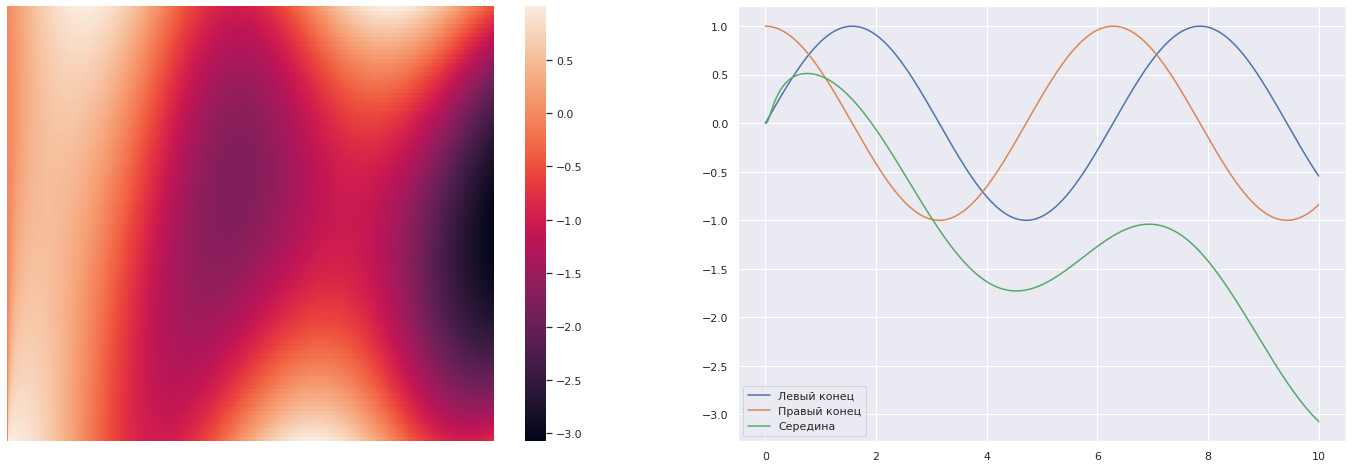

In [11]:
explicit_schema = get_equation_solver('non_explicit')
right = lambda t: np.cos(t)
left = lambda t: np.sin(t)
f = lambda x, t: -t
initial = lambda x: 0
explicit_schema(left=left, right=right, kappa=0.5, x_precision=100, time_precision=1000, f=f, initial=initial).plot()

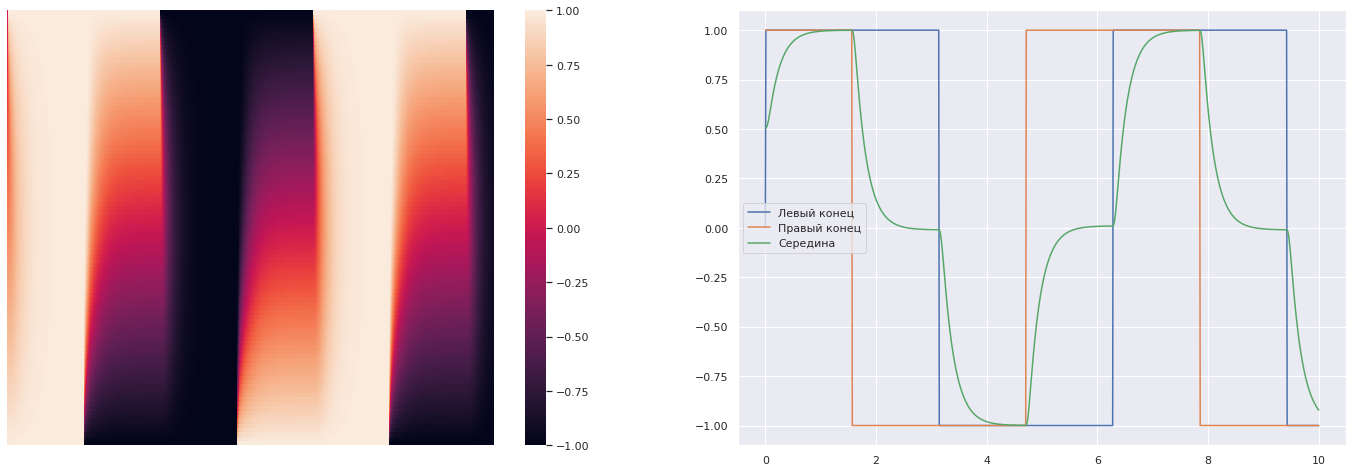

In [15]:
explicit_schema = get_equation_solver('non_explicit')
right = lambda t: np.sign(np.cos(t))
left = lambda t: np.sign(np.sin(t))
f = lambda x, t: 0
initial = lambda x: (1-x) * left(0) + x * right(0)
explicit_schema(left=left, right=right, kappa=0.5, x_precision=100, time_precision=1000, f=f, initial=initial).plot()